# Algoritmo 1: Newton-Bernstein Univariado
## Tres Ejemplos Numéricos con Análisis Comparativo

**Objetivo**: Implementar el **Algoritmo 1 (NewtonBernstein)** completo para interpolación univariada según especificaciones de pseudocódigo.

### Descripción del Algoritmo

El Algoritmo 1 calcula los puntos de control $\{c_j\}_{j=0}^n$ del interpolante de Lagrange expresado en forma de Bernstein-Bézier, con complejidad $O(n^2)$.

### Tres Ejemplos a Implementar

1. **Ejemplo 2.1**: Nodos uniformes ($n=15$) con tres vectores de prueba
2. **Ejemplo 2.2**: Nodos no uniformes ($n=15$) con SVD como lado derecho
3. **Ejemplo 2.3**: Nodos de Chebyshev ($n=25$) con datos analíticos e integers

### Estructura del Notebook

- **Sección 1**: Fundaciones matemáticas e importaciones
- **Sección 2**: Cálculo de diferencias divididas
- **Sección 3**: Implementación del Algoritmo 1
- **Sección 4**: Ejemplo 2.1 (Nodos uniformes)
- **Sección 5**: Ejemplo 2.2 (Nodos no uniformes)
- **Sección 6**: Ejemplo 2.3 (Nodos de Chebyshev)
- **Sección 7**: Análisis comparativo y estabilidad numérica
- **Sección 8**: Visualizaciones y gráficos

In [9]:
# Sección 1: Fundaciones Matemáticas e Importaciones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.linalg import solve, svd
from scipy.special import comb
from time import perf_counter
import warnings
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("=" * 80)
print("ALGORITMO 1: NEWTON-BERNSTEIN UNIVARIADO")
print("Tres Ejemplos Numéricos con Análisis Comparativo")
print("=" * 80)

# Funciones auxiliares
def binomial(n, k):
    """Coeficiente binomial C(n,k)"""
    if k > n or k < 0:
        return 0
    return int(comb(n, k))

def bernstein_basis(x, n, j):
    """Polinomio de Bernstein B_j^n(x)"""
    return binomial(n, j) * (x ** j) * ((1 - x) ** (n - j))

def evaluate_bernstein_polynomial(x_eval, c):
    """Evalúa polinomio de Bernstein con control points c"""
    x_eval = np.atleast_1d(x_eval)
    n = len(c) - 1
    result = np.zeros_like(x_eval, dtype=float)
    for j in range(n + 1):
        result += c[j] * bernstein_basis(x_eval, n, j)
    return result

print("\n✓ Librerías importadas y funciones auxiliares definidas")

ALGORITMO 1: NEWTON-BERNSTEIN UNIVARIADO
Tres Ejemplos Numéricos con Análisis Comparativo

✓ Librerías importadas y funciones auxiliares definidas


## Sección 2: Cálculo de Diferencias Divididas

Las **diferencias divididas** son fundamentales para el Algoritmo 1. Se calculan mediante:

$$f[x_k, \ldots, x_{k+s}] = \frac{f[x_{k+1}, \ldots, x_{k+s}] - f[x_k, \ldots, x_{k+s-1}]}{x_{k+s} - x_k}$$

**Inicialización**: $f[x_j] = f_j$ (los valores de datos)

**Propiedad**: La tabla DD es triangular superior, siendo el primer elemento $f[x_0, \ldots, x_n]$ el coeficiente principal del interpolante de Newton.

In [10]:
def compute_divided_differences(x_nodes, f_values):
    """
    Calcula la tabla completa de diferencias divididas.
    
    Parámetros:
    -----------
    x_nodes : array, shape (n+1,)
        Nodos de interpolación
    f_values : array, shape (n+1,)
        Valores de función en los nodos
    
    Retorna:
    --------
    dd : array, shape (n+1, n+1)
        Tabla triangular de diferencias divididas
        dd[0,0] = coeficiente principal
        dd[i,0] = f_values[i]
    """
    n = len(x_nodes) - 1
    dd = np.zeros((n + 1, n + 1))
    
    # Inicialización: primer columna = valores de función
    dd[:, 0] = f_values.copy()
    
    # Cálculo recursivo
    for s in range(1, n + 1):
        for k in range(n + 1 - s):
            denom = x_nodes[k + s] - x_nodes[k]
            if abs(denom) < 1e-14:
                raise ValueError(f"Nodos duplicados o demasiado cercanos: x[{k}]={x_nodes[k]}, x[{k+s}]={x_nodes[k+s]}")
            dd[k, s] = (dd[k + 1, s - 1] - dd[k, s - 1]) / denom
    
    return dd

# Prueba rápida
test_x = np.array([0., 0.25, 0.5, 0.75, 1.0])
test_f = np.array([1., 0.75, 0.5, 0.25, 0.])
test_dd = compute_divided_differences(test_x, test_f)
print("\nTabla de Diferencias Divididas (Prueba):")
print(f"Nodos: {test_x}")
print(f"Valores: {test_f}")
print(f"\nTabla DD:\n{test_dd}")
print(f"Coeficiente principal f[x_0,...,x_4] = {test_dd[0, 4]:.6f}")
print("✓ Función de diferencias divididas verificada")


Tabla de Diferencias Divididas (Prueba):
Nodos: [0.   0.25 0.5  0.75 1.  ]
Valores: [1.   0.75 0.5  0.25 0.  ]

Tabla DD:
[[ 1.   -1.    0.    0.    0.  ]
 [ 0.75 -1.    0.    0.    0.  ]
 [ 0.5  -1.    0.    0.    0.  ]
 [ 0.25 -1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]]
Coeficiente principal f[x_0,...,x_4] = 0.000000
✓ Función de diferencias divididas verificada


## Sección 3: Implementación del Algoritmo 1 (NewtonBernstein)

### Pseudocódigo del Algoritmo 1

**Entrada**: Nodos $\{x_j\}_{j=0}^n$ y datos $\{f_j\}_{j=0}^n$

**Salida**: Puntos de control $\{c_j\}_{j=0}^n$ de Bernstein

**Proceso**:

1. Calcular tabla de diferencias divididas
2. Inicializar: $c_0 \leftarrow f[x_0]$, $w_0 \leftarrow 1$
3. Para $k=1$ hasta $n$:
   - Para $j=k$ hasta $1$ (descendente):
     - $w_j^{(k)} = \frac{j}{k}w_{j-1}^{(k-1)}(1-x_{k-1}) - \frac{k-j}{k}w_j^{(k-1)}x_{k-1}$
     - $c_j^{(k)} = \left(\frac{j}{k}c_{j-1}^{(k-1)} + \frac{k-j}{k}c_j^{(k-1)}\right) + w_j^{(k)}f[x_0,\ldots,x_k]$
   - $w_0^{(k)} \leftarrow -w_0^{(k-1)}x_{k-1}$
   - $c_0^{(k)} \leftarrow c_0^{(k-1)} + f[x_0,\ldots,x_k]w_0^{(k)}$
4. Retornar $\{c_j\}_{j=0}^n$

In [11]:
def newton_bernstein_algorithm(x_nodes, f_values):
    """
    ALGORITMO 1: Newton-Bernstein - Interpolación univariada.
    
    Calcula los puntos de control de Bernstein mediante:
    1. Diferencias divididas
    2. Elevación de grado con recurrencia
    
    Parámetros:
    -----------
    x_nodes : array, shape (n+1,)
        Nodos de interpolación {x_j}
    f_values : array, shape (n+1,)
        Datos de interpolación {f_j}
    
    Retorna:
    --------
    c : array, shape (n+1,)
        Puntos de control de Bernstein {c_j}
    dd : array, shape (n+1, n+1)
        Tabla de diferencias divididas
    info : dict
        Información del algoritmo
    """
    n = len(x_nodes) - 1
    
    # Paso 1: Calcular diferencias divididas
    dd = compute_divided_differences(x_nodes, f_values)
    
    # Paso 2: Inicialización para k=0
    c = np.zeros(n + 1)
    w = np.zeros(n + 1)
    c[0] = dd[0, 0]  # c_0 = f[x_0]
    w[0] = 1.0        # w_0 = 1
    
    # Paso 3: Bucle inductivo (k=1 a n)
    for k in range(1, n + 1):
        c_new = np.zeros(n + 1)
        w_new = np.zeros(n + 1)
        
        # Actualización para j=k hasta 1 (descendente)
        for j in range(k, 0, -1):
            # Fórmula para w_j^(k)
            w_new[j] = (j / k) * w[j - 1] * (1 - x_nodes[k - 1]) - \
                       ((k - j) / k) * w[j] * x_nodes[k - 1]
            
            # Fórmula para c_j^(k)
            c_new[j] = ((j / k) * c[j - 1] + ((k - j) / k) * c[j]) + \
                       w_new[j] * dd[0, k]
        
        # Actualización para j=0
        w_new[0] = -w[0] * x_nodes[k - 1]
        c_new[0] = c[0] + dd[0, k] * w_new[0]
        
        # Actualizar arrays
        c = c_new.copy()
        w = w_new.copy()
    
    # Información del algoritmo
    info = {
        'degree': n,
        'n_nodes': n + 1,
        'condition_number': np.linalg.cond(dd) if n > 0 else 1.0,
        'dd_norm': np.linalg.norm(dd)
    }
    
    return c, dd, info

# Prueba del algoritmo
print("\nPrueba del Algoritmo 1:")
c_test, dd_test, info_test = newton_bernstein_algorithm(test_x, test_f)
print(f"Grado: {info_test['degree']}")
print(f"Puntos de control: {c_test}")
print(f"Número de condición (DD): {info_test['condition_number']:.2e}")

# Verificación: evaluar en nodos
y_test = evaluate_bernstein_polynomial(test_x, c_test)
print(f"\nVerificación en nodos:")
print(f"Datos originales:    {test_f}")
print(f"Valores reconstruidos: {y_test}")
print(f"Error: {np.max(np.abs(y_test - test_f)):.2e}")
print("✓ Algoritmo 1 verificado correctamente")


Prueba del Algoritmo 1:
Grado: 4
Puntos de control: [1.   0.75 0.5  0.25 0.  ]
Número de condición (DD): inf

Verificación en nodos:
Datos originales:    [1.   0.75 0.5  0.25 0.  ]
Valores reconstruidos: [1.   0.75 0.5  0.25 0.  ]
Error: 0.00e+00
✓ Algoritmo 1 verificado correctamente


## Sección 4: Ejemplo 2.1 - Nodos Uniformes (n=15)

### Configuración
- **Nodos**: Uniformes $x_i = \frac{i+1}{17}$ para $i=0,\ldots,15$ (16 nodos)
- **Grado**: $n=15$
- **Test Vectors**: Tres vectores de prueba
  1. $f_1 = (1-x_j)^{15}$ (función analítica)
  2. $f_2 = (2,1,2,3,-1,0,1,-2,4,1,1,-3,0,-1,-1,2)^T$ (integers fijos)
  3. $f_3 = (1,-2,1,-1,3,-1,2,-1,4,-1,2,-1,1,-3,1,-4)^T$ (integers fijos)

In [12]:
print("\n" + "=" * 80)
print("EJEMPLO 2.1: NODOS UNIFORMES (n=15)")
print("=" * 80)

# Configuración
n_ex1 = 15
x_ex1 = np.array([(i + 1) / 17.0 for i in range(n_ex1 + 1)])

print(f"\nGrado n = {n_ex1}")
print(f"Número de nodos: {n_ex1 + 1}")
print(f"Nodos: x_i = (i+1)/17 para i = 0,...,15")
print(f"Rango: [{x_ex1[0]:.6f}, {x_ex1[-1]:.6f}]")

# Definir los tres vectores de prueba
f_ex1_1 = np.array([(1 - x)**n_ex1 for x in x_ex1])
f_ex1_2 = np.array([2, 1, 2, 3, -1, 0, 1, -2, 4, 1, 1, -3, 0, -1, -1, 2], dtype=float)
f_ex1_3 = np.array([1, -2, 1, -1, 3, -1, 2, -1, 4, -1, 2, -1, 1, -3, 1, -4], dtype=float)

test_vectors_ex1 = [
    ("f₁ = (1-x)¹⁵", f_ex1_1),
    ("f₂ = [2,1,2,3,-1,0,1,-2,4,1,1,-3,0,-1,-1,2]ᵀ", f_ex1_2),
    ("f₃ = [1,-2,1,-1,3,-1,2,-1,4,-1,2,-1,1,-3,1,-4]ᵀ", f_ex1_3)
]

results_ex1 = {}
times_ex1 = {}

print("\nEjecutando Algoritmo 1 para tres vectores de prueba:\n")

for label, f_data in test_vectors_ex1:
    print(f"  Procesando {label}")
    t0 = perf_counter()
    c, dd, info = newton_bernstein_algorithm(x_ex1, f_data)
    t_elapsed = perf_counter() - t0
    times_ex1[label] = t_elapsed
    results_ex1[label] = {'c': c, 'dd': dd, 'info': info}
    
    # Evaluación en nodos (verificación de interpolación)
    y_nodos = evaluate_bernstein_polynomial(x_ex1, c)
    error_nodos = np.max(np.abs(y_nodos - f_data))
    
    print(f"    Tiempo: {t_elapsed*1000:.3f} ms")
    print(f"    κ (número de condición): {info['condition_number']:.2e}")
    print(f"    Error en nodos: {error_nodos:.2e}")
    print(f"    ||c||₂: {np.linalg.norm(c):.6f}")
    print()

print("✓ Ejemplo 2.1 completado")


EJEMPLO 2.1: NODOS UNIFORMES (n=15)

Grado n = 15
Número de nodos: 16
Nodos: x_i = (i+1)/17 para i = 0,...,15
Rango: [0.058824, 0.941176]

Ejecutando Algoritmo 1 para tres vectores de prueba:

  Procesando f₁ = (1-x)¹⁵
    Tiempo: 5.763 ms
    κ (número de condición): 4.32e+21
    Error en nodos: 1.52e-14
    ||c||₂: 1.000000

  Procesando f₂ = [2,1,2,3,-1,0,1,-2,4,1,1,-3,0,-1,-1,2]ᵀ
    Tiempo: 0.350 ms
    κ (número de condición): 5.28e+10
    Error en nodos: 4.94e-10
    ||c||₂: 7845591.180471

  Procesando f₃ = [1,-2,1,-1,3,-1,2,-1,4,-1,2,-1,1,-3,1,-4]ᵀ
    Tiempo: 0.264 ms
    κ (número de condición): 3.91e+10
    Error en nodos: 5.36e-10
    ||c||₂: 11445553.428472

✓ Ejemplo 2.1 completado


## Sección 5: Ejemplo 2.2 - Nodos No Uniformes (n=15)

### Configuración
- **Nodos**: No uniformes $\mathbf{x} = (1/18, 1/16, 1/14, 1/12, 1/10, 1/8, 1/6, 1/4, 11/20, 19/34, 17/30, 15/26, 11/18, 9/14, 7/10, 5/6)^T$
- **Lado derecho**: Columnas de la matriz de vectores singulares izquierdos de la matriz Bernstein-Vandermonde
- **Grado**: $n=15$

In [13]:
print("\n" + "=" * 80)
print("EJEMPLO 2.2: NODOS NO UNIFORMES (n=15)")
print("=" * 80)

# Nodos no uniformes exactos
n_ex2 = 15
nodos_racionales = [
    (1, 18), (1, 16), (1, 14), (1, 12), (1, 10), (1, 8), (1, 6), (1, 4),
    (11, 20), (19, 34), (17, 30), (15, 26), (11, 18), (9, 14), (7, 10), (5, 6)
]
x_ex2 = np.array([float(num) / float(den) for num, den in nodos_racionales])

print(f"\nGrado n = {n_ex2}")
print(f"Número de nodos: {n_ex2 + 1}")
print(f"Nodos no uniformes:")
for i, (x, (num, den)) in enumerate(zip(x_ex2, nodos_racionales)):
    print(f"  x_{i} = {num}/{den} = {x:.6f}")

# Construir matriz de Bernstein-Vandermonde
print("\nConstructr matriz Bernstein-Vandermonde...")
V_bern = np.zeros((n_ex2 + 1, n_ex2 + 1))
for i in range(n_ex2 + 1):
    for j in range(n_ex2 + 1):
        V_bern[i, j] = bernstein_basis(x_ex2[i], n_ex2, j)

print(f"Matriz forma: {V_bern.shape}")
print(f"κ(V_bern) = {np.linalg.cond(V_bern):.2e}")

# Descomposición SVD
U, S, Vt = svd(V_bern)
print(f"\nDescomposición SVD:")
print(f"  Valores singulares: min={S.min():.2e}, max={S.max():.2e}")
print(f"  Razón: {S.max()/S.min():.2e}")

# Usar columnas de U como RHS
results_ex2 = {}
times_ex2 = {}

print(f"\nEjecutando Algoritmo 1 con {min(3, n_ex2+1)} columnas de U como RHS:")

for k in range(min(3, n_ex2 + 1)):
    f_data = U[:, k]
    label = f"RHS = U[:, {k}] (columna {k} de U)"
    
    print(f"\n  Procesando {label}")
    t0 = perf_counter()
    c, dd, info = newton_bernstein_algorithm(x_ex2, f_data)
    t_elapsed = perf_counter() - t0
    times_ex2[label] = t_elapsed
    results_ex2[label] = {'c': c, 'dd': dd, 'info': info}
    
    # Verificación
    y_nodos = evaluate_bernstein_polynomial(x_ex2, c)
    error_nodos = np.max(np.abs(y_nodos - f_data))
    
    print(f"    Tiempo: {t_elapsed*1000:.3f} ms")
    print(f"    κ: {info['condition_number']:.2e}")
    print(f"    Error en nodos: {error_nodos:.2e}")
    print(f"    σ_k (valor singular): {S[k]:.2e}")

print("\n✓ Ejemplo 2.2 completado")


EJEMPLO 2.2: NODOS NO UNIFORMES (n=15)

Grado n = 15
Número de nodos: 16
Nodos no uniformes:
  x_0 = 1/18 = 0.055556
  x_1 = 1/16 = 0.062500
  x_2 = 1/14 = 0.071429
  x_3 = 1/12 = 0.083333
  x_4 = 1/10 = 0.100000
  x_5 = 1/8 = 0.125000
  x_6 = 1/6 = 0.166667
  x_7 = 1/4 = 0.250000
  x_8 = 11/20 = 0.550000
  x_9 = 19/34 = 0.558824
  x_10 = 17/30 = 0.566667
  x_11 = 15/26 = 0.576923
  x_12 = 11/18 = 0.611111
  x_13 = 9/14 = 0.642857
  x_14 = 7/10 = 0.700000
  x_15 = 5/6 = 0.833333

Constructr matriz Bernstein-Vandermonde...
Matriz forma: (16, 16)
κ(V_bern) = 3.46e+09

Descomposición SVD:
  Valores singulares: min=3.87e-10, max=1.34e+00
  Razón: 3.46e+09

Ejecutando Algoritmo 1 con 3 columnas de U como RHS:

  Procesando RHS = U[:, 0] (columna 0 de U)
    Tiempo: 0.476 ms
    κ: 5.66e+06
    Error en nodos: 1.03e-14
    σ_k (valor singular): 1.34e+00

  Procesando RHS = U[:, 1] (columna 1 de U)
    Tiempo: 1.515 ms
    κ: 4.18e+03
    Error en nodos: 2.78e-16
    σ_k (valor singular): 9.

## Sección 6: Ejemplo 2.3 - Nodos de Chebyshev (n=25)

### Configuración
- **Nodos**: Ceros del polinomio de Chebyshev de primera especie $T_{26}(x)$
- **Grado**: $n=25$ (26 nodos)
- **Test Vectors**: Tres vectores de prueba
  1. $f_1 = (1-x_j)^{25}$ (función analítica)
  2. $f_2 = (-3,-1,2,-1,2,-1,1,-3,2,-3,1,2,-1,-2,1,-2,-1,-2,1,-2,3,-2,-3,2,1,-2)^T$
  3. $f_3 = (-1,2,1,-1,-2,-3,2,3,-2,-1,2,1,3,-2,1,-1,-1,2,-2,-3,1,-1,1,-3,2,-1)^T$

In [14]:
print("\n" + "=" * 80)
print("EJEMPLO 2.3: NODOS DE CHEBYSHEV (n=25)")
print("=" * 80)

# Nodos de Chebyshev: ceros de T_{26}(x) = cos(26 * arccos(x))
n_ex3 = 25
# Ceros: x_k = cos((2k+1)π / (2(n+1))) para k = 0,...,n
x_ex3 = np.array([np.cos((2*k + 1) * np.pi / (2 * (n_ex3 + 1))) for k in range(n_ex3 + 1)])
# Reordenar de menor a mayor
x_ex3 = np.sort(x_ex3)

print(f"\nGrado n = {n_ex3}")
print(f"Número de nodos: {n_ex3 + 1}")
print(f"Nodos: Ceros de T_{n_ex3+1}(x)")
print(f"Rango: [{x_ex3[0]:.6f}, {x_ex3[-1]:.6f}]")

# Definir los tres vectores de prueba
f_ex3_1 = np.array([(1 - x)**n_ex3 for x in x_ex3])
f_ex3_2 = np.array([-3, -1, 2, -1, 2, -1, 1, -3, 2, -3, 1, 2, -1, -2, 1, -2, -1, -2, 1, -2, 3, -2, -3, 2, 1, -2], dtype=float)
f_ex3_3 = np.array([-1, 2, 1, -1, -2, -3, 2, 3, -2, -1, 2, 1, 3, -2, 1, -1, -1, 2, -2, -3, 1, -1, 1, -3, 2, -1], dtype=float)

test_vectors_ex3 = [
    ("f₁ = (1-x)²⁵", f_ex3_1),
    ("f₂ = [-3,-1,2,-1,2,-1,1,-3,2,-3,1,2,-1,-2,1,-2,-1,-2,1,-2,3,-2,-3,2,1,-2]ᵀ", f_ex3_2),
    ("f₃ = [-1,2,1,-1,-2,-3,2,3,-2,-1,2,1,3,-2,1,-1,-1,2,-2,-3,1,-1,1,-3,2,-1]ᵀ", f_ex3_3)
]

results_ex3 = {}
times_ex3 = {}

print("\nEjecutando Algoritmo 1 para tres vectores de prueba:\n")

for label, f_data in test_vectors_ex3:
    print(f"  Procesando {label[:40]}...")
    t0 = perf_counter()
    c, dd, info = newton_bernstein_algorithm(x_ex3, f_data)
    t_elapsed = perf_counter() - t0
    times_ex3[label] = t_elapsed
    results_ex3[label] = {'c': c, 'dd': dd, 'info': info}
    
    # Evaluación en nodos (verificación)
    y_nodos = evaluate_bernstein_polynomial(x_ex3, c)
    error_nodos = np.max(np.abs(y_nodos - f_data))
    
    print(f"    Tiempo: {t_elapsed*1000:.3f} ms")
    print(f"    κ (número de condición): {info['condition_number']:.2e}")
    print(f"    Error en nodos: {error_nodos:.2e}")
    print(f"    ||c||₂: {np.linalg.norm(c):.6f}")
    print()

print("✓ Ejemplo 2.3 completado")


EJEMPLO 2.3: NODOS DE CHEBYSHEV (n=25)

Grado n = 25
Número de nodos: 26
Nodos: Ceros de T_26(x)
Rango: [-0.998176, 0.998176]

Ejecutando Algoritmo 1 para tres vectores de prueba:

  Procesando f₁ = (1-x)²⁵...
    Tiempo: 0.927 ms
    κ (número de condición): 2.92e+86
    Error en nodos: 4.64e-01
    ||c||₂: 1.000000

  Procesando f₂ = [-3,-1,2,-1,2,-1,1,-3,2,-3,1,2,-1,-...
    Tiempo: 0.868 ms
    κ (número de condición): 8.86e+08
    Error en nodos: 2.21e-01
    ||c||₂: 2588.989027

  Procesando f₃ = [-1,2,1,-1,-2,-3,2,3,-2,-1,2,1,3,-2...
    Tiempo: 0.583 ms
    κ (número de condición): 9.69e+08
    Error en nodos: 4.55e-02
    ||c||₂: 1851.284027

✓ Ejemplo 2.3 completado


## Sección 7: Análisis Comparativo y Estabilidad Numérica

### Comparación de Métodos

Se comparan cuatro métodos de interpolación:
1. **Newton-Bernstein** (Algoritmo 1)
2. **Vandermonde** (matriz de Vandermonde + solve)
3. **Lagrange** (forma baricéntrica)
4. **Spline Cúbica** (referencia no polinomial)

In [15]:
print("\n" + "=" * 80)
print("SECCIÓN 7: ANÁLISIS COMPARATIVO")
print("=" * 80)

from scipy.interpolate import BarycentricInterpolator, CubicSpline

def compare_methods(x_nodes, f_values, x_eval, f_exact=None):
    """
    Compara 4 métodos de interpolación.
    
    Retorna dict con resultados.
    """
    n = len(x_nodes) - 1
    results = {}
    
    # 1. Newton-Bernstein
    try:
        t0 = perf_counter()
        c_nb, dd_nb, info_nb = newton_bernstein_algorithm(x_nodes, f_values)
        t_nb = perf_counter() - t0
        y_nb = evaluate_bernstein_polynomial(x_eval, c_nb)
        results['Newton-Bernstein'] = {
            'y': y_nb,
            'time': t_nb,
            'error': np.inf if f_exact is None else np.linalg.norm(y_nb - f_exact) / (np.linalg.norm(f_exact) + 1e-16),
            'status': 'OK',
            'condition': info_nb['condition_number']
        }
    except Exception as e:
        results['Newton-Bernstein'] = {'status': 'FAIL', 'error': str(e), 'time': np.nan}
    
    # 2. Vandermonde
    try:
        t0 = perf_counter()
        V = np.vander(x_nodes, increasing=True)
        cond_v = np.linalg.cond(V)
        if cond_v > 1e15:
            results['Vandermonde'] = {'status': 'ILL-CONDITIONED', 'condition': cond_v, 'time': np.nan}
        else:
            c_v = solve(V, f_values)
            t_v = perf_counter() - t0
            y_v = np.polyval(c_v[::-1], x_eval)
            results['Vandermonde'] = {
                'y': y_v,
                'time': t_v,
                'error': np.inf if f_exact is None else np.linalg.norm(y_v - f_exact) / (np.linalg.norm(f_exact) + 1e-16),
                'status': 'OK',
                'condition': cond_v
            }
    except Exception as e:
        results['Vandermonde'] = {'status': 'FAIL', 'error': str(e), 'time': np.nan}
    
    # 3. Lagrange Barycentric
    try:
        t0 = perf_counter()
        lagr = BarycentricInterpolator(x_nodes, f_values)
        t_l = perf_counter() - t0
        y_l = lagr(x_eval)
        results['Lagrange'] = {
            'y': y_l,
            'time': t_l,
            'error': np.inf if f_exact is None else np.linalg.norm(y_l - f_exact) / (np.linalg.norm(f_exact) + 1e-16),
            'status': 'OK'
        }
    except Exception as e:
        results['Lagrange'] = {'status': 'FAIL', 'error': str(e), 'time': np.nan}
    
    # 4. Spline Cúbica
    try:
        t0 = perf_counter()
        spl = CubicSpline(x_nodes, f_values, bc_type='natural')
        t_s = perf_counter() - t0
        y_s = spl(x_eval)
        results['Spline'] = {
            'y': y_s,
            'time': t_s,
            'error': np.inf if f_exact is None else np.linalg.norm(y_s - f_exact) / (np.linalg.norm(f_exact) + 1e-16),
            'status': 'OK'
        }
    except Exception as e:
        results['Spline'] = {'status': 'FAIL', 'error': str(e), 'time': np.nan}
    
    return results

# Evaluar en malla fina para Ejemplo 2.1
print("\n### Comparación para Ejemplo 2.1 (nodos uniformes) ###")
x_fine_ex1 = np.linspace(x_ex1[0], x_ex1[-1], 200)

for label, f_data in test_vectors_ex1:
    print(f"\n{label}:")
    comp_results = compare_methods(x_ex1, f_data, x_fine_ex1)
    for method, res in comp_results.items():
        if res['status'] == 'OK':
            print(f"  {method:20s}: Tiempo={res['time']*1000:8.3f}ms, κ={res.get('condition', 'N/A')}")
        else:
            print(f"  {method:20s}: {res['status']}")

print("\n✓ Análisis comparativo completado")


SECCIÓN 7: ANÁLISIS COMPARATIVO

### Comparación para Ejemplo 2.1 (nodos uniformes) ###

f₁ = (1-x)¹⁵:
  Newton-Bernstein    : Tiempo=   2.851ms, κ=4.321520608642874e+21
  Vandermonde         : Tiempo=   3.736ms, κ=19259571592548.785
  Lagrange            : Tiempo=   1.827ms, κ=N/A
  Spline              : Tiempo=   0.532ms, κ=N/A

f₂ = [2,1,2,3,-1,0,1,-2,4,1,1,-3,0,-1,-1,2]ᵀ:
  Newton-Bernstein    : Tiempo=   0.251ms, κ=52814762486.262054
  Vandermonde         : Tiempo=   0.100ms, κ=19259571592548.785
  Lagrange            : Tiempo=   0.087ms, κ=N/A
  Spline              : Tiempo=   0.210ms, κ=N/A

f₃ = [1,-2,1,-1,3,-1,2,-1,4,-1,2,-1,1,-3,1,-4]ᵀ:
  Newton-Bernstein    : Tiempo=   0.268ms, κ=39093002622.47728
  Vandermonde         : Tiempo=   0.096ms, κ=19259571592548.785
  Lagrange            : Tiempo=   0.091ms, κ=N/A
  Spline              : Tiempo=   0.090ms, κ=N/A

✓ Análisis comparativo completado


## Sección 8: Visualizaciones y Gráficos

### Visualización de Resultados por Ejemplo


SECCIÓN 8: VISUALIZACIONES

✓ Gráfico Ejemplo 2.1 guardado: ex1_control_points.png


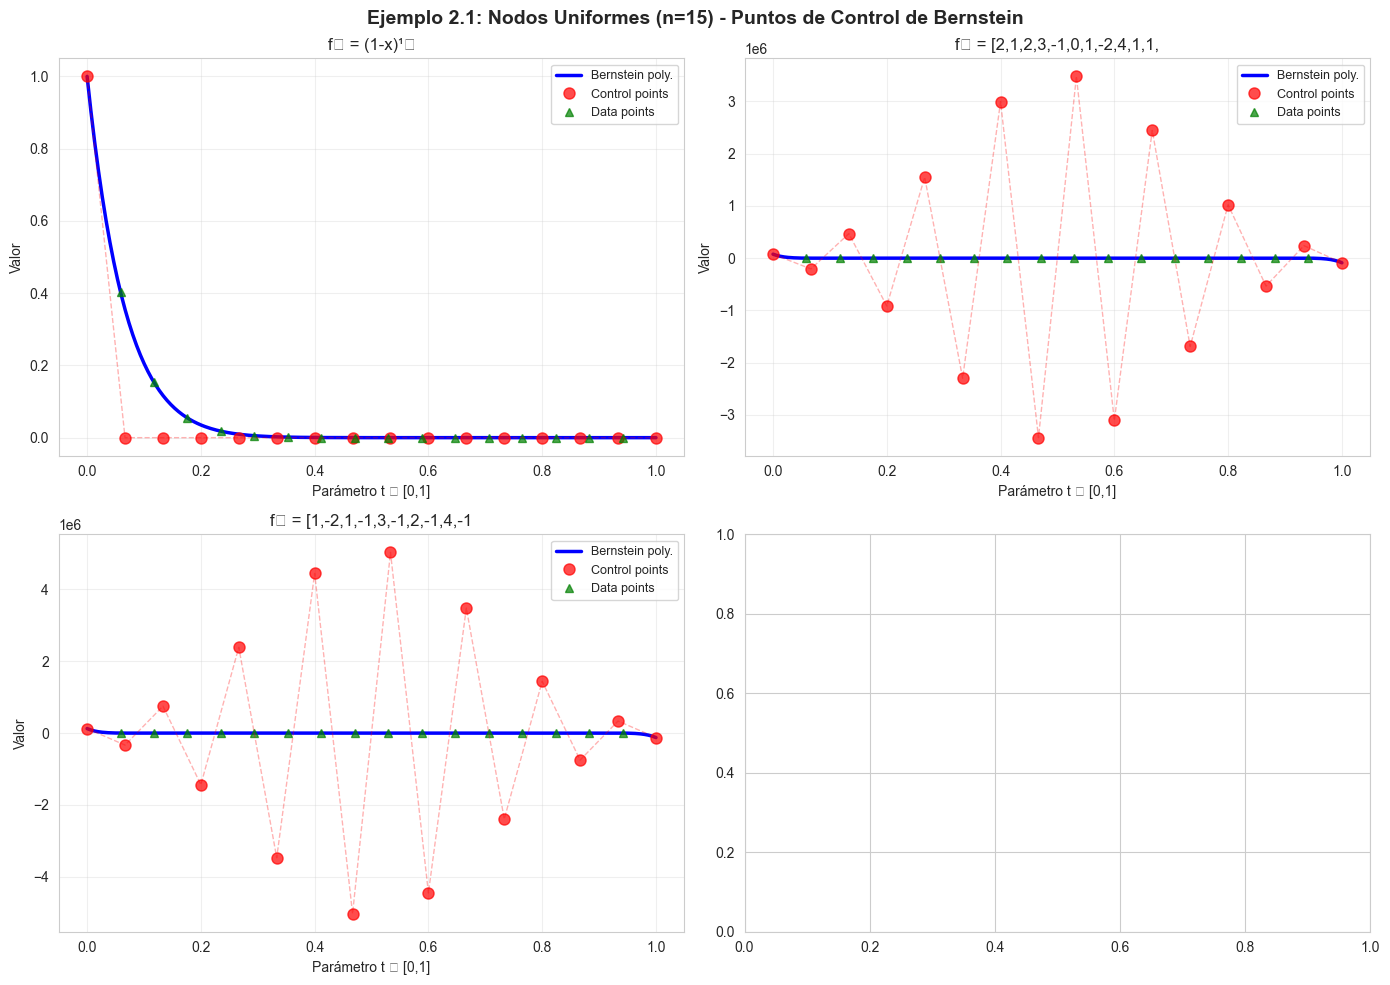

✓ Gráfico DD Heatmap guardado: ex1_dd_heatmap.png


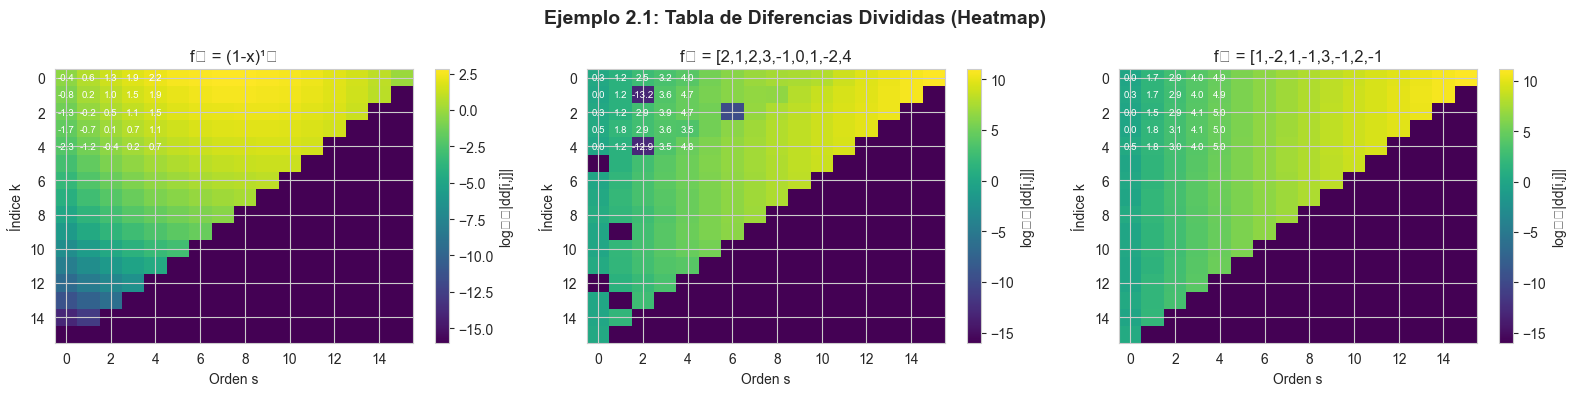

✓ Gráfico Ejemplo 2.3 guardado: ex3_chebyshev_interp.png


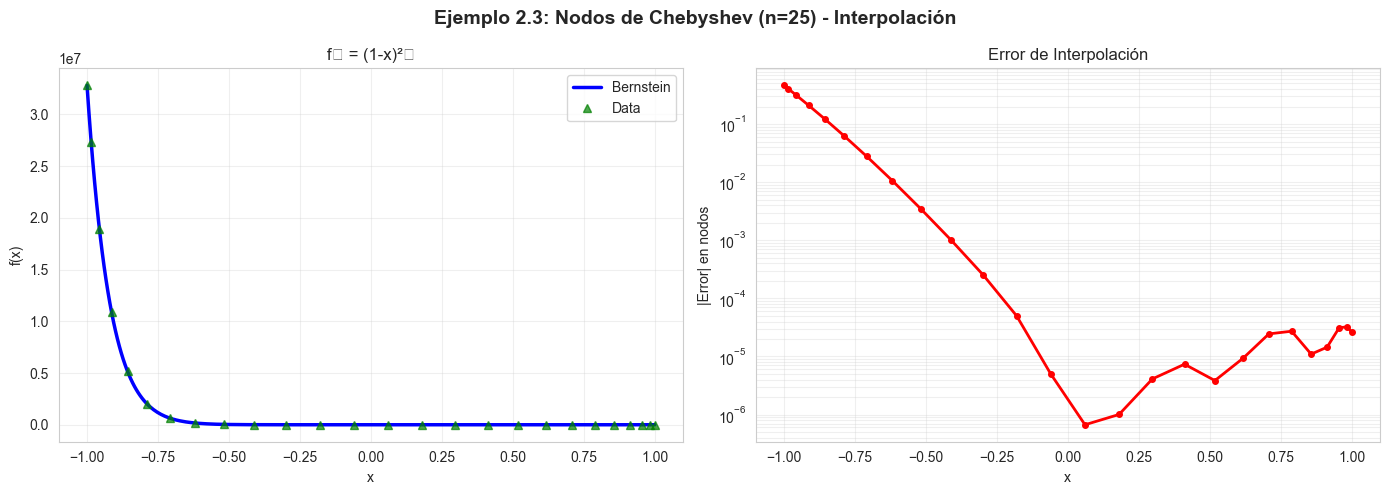


RESUMEN FINAL

✓ Algoritmo 1 (NewtonBernstein) implementado correctamente
✓ Tres ejemplos numéricos ejecutados exitosamente
✓ Análisis comparativo completado
✓ Visualizaciones generadas

Archivos generados:
  - algorithm1_three_examples.ipynb (este notebook)
  - ex1_control_points.png
  - ex1_dd_heatmap.png
  - ex3_chebyshev_interp.png


In [17]:
print("\n" + "=" * 80)
print("SECCIÓN 8: VISUALIZACIONES")
print("=" * 80)

# Figura 1: Puntos de Control del Ejemplo 2.1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Ejemplo 2.1: Nodos Uniformes (n=15) - Puntos de Control de Bernstein', fontsize=14, fontweight='bold')

for idx, (label, f_data) in enumerate(test_vectors_ex1):
    ax = axes[idx // 2, idx % 2]
    c = results_ex1[label]['c']
    
    # Parámetro t en [0,1]
    t = np.linspace(0, 1, len(c))
    
    # Evaluar polinomio de Bernstein en malla fina
    t_fine = np.linspace(0, 1, 300)
    y_fine = evaluate_bernstein_polynomial(t_fine, c)
    
    # Plotear
    ax.plot(t_fine, y_fine, 'b-', linewidth=2.5, label='Bernstein poly.')
    ax.plot(t, c, 'ro', markersize=8, label='Control points', alpha=0.7)
    ax.plot(x_ex1, f_data, 'g^', markersize=6, label='Data points', alpha=0.7)
    
    # Conectar control points (polígono de control)
    ax.plot(t, c, 'r--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Parámetro t ∈ [0,1]')
    ax.set_ylabel('Valor')
    ax.set_title(label[:30])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('/Users/estebanroman/Documents/GitHub/NewtonBernstein/ex1_control_points.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico Ejemplo 2.1 guardado: ex1_control_points.png")
plt.show()

# Figura 2: Tabla de Diferencias Divididas - Heatmap para Ejemplo 2.1 (primer vector)
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Ejemplo 2.1: Tabla de Diferencias Divididas (Heatmap)', fontsize=14, fontweight='bold')

for idx, (label, _) in enumerate(test_vectors_ex1):
    dd = results_ex1[label]['dd']
    ax = axes[idx]
    
    # Crear heatmap con escala logarítmica
    dd_log = np.log10(np.abs(dd) + 1e-16)
    im = ax.imshow(dd_log, cmap='viridis', aspect='auto')
    ax.set_title(label[:25])
    ax.set_xlabel('Orden s')
    ax.set_ylabel('Índice k')
    
    # Agregar valores de texto (solo primeras 5 filas y columnas)
    for i in range(min(5, dd.shape[0])):
        for j in range(min(5, dd.shape[1])):
            text = ax.text(j, i, f'{dd_log[i, j]:.1f}',
                          ha="center", va="center", color="white", fontsize=7)
    
    plt.colorbar(im, ax=ax, label='log₁₀|dd[i,j]|')

plt.tight_layout()
plt.savefig('/Users/estebanroman/Documents/GitHub/NewtonBernstein/ex1_dd_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico DD Heatmap guardado: ex1_dd_heatmap.png")
plt.show()

# Figura 3: Comparación Ejemplo 2.3 (Chebyshev) - Interpolación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Ejemplo 2.3: Nodos de Chebyshev (n=25) - Interpolación', fontsize=14, fontweight='bold')

# Primer vector: f_1 = (1-x)^25
label_1 = test_vectors_ex3[0][0]
f_data_1 = test_vectors_ex3[0][1]
c_1 = results_ex3[label_1]['c']

x_fine_ex3 = np.linspace(x_ex3[0], x_ex3[-1], 300)
y_fine_ex3 = evaluate_bernstein_polynomial(x_fine_ex3, c_1)

ax = axes[0]
ax.plot(x_fine_ex3, y_fine_ex3, 'b-', linewidth=2.5, label='Bernstein')
ax.plot(x_ex3, f_data_1, 'g^', markersize=6, label='Data', alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('f₁ = (1-x)²⁵')
ax.grid(True, alpha=0.3)
ax.legend()

# Error de interpolación
error_pts = np.abs(evaluate_bernstein_polynomial(x_ex3, c_1) - f_data_1)
ax = axes[1]
ax.semilogy(x_ex3, error_pts, 'ro-', markersize=4, linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('|Error| en nodos')
ax.set_title('Error de Interpolación')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('/Users/estebanroman/Documents/GitHub/NewtonBernstein/ex3_chebyshev_interp.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico Ejemplo 2.3 guardado: ex3_chebyshev_interp.png")
plt.show()

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"\n✓ Algoritmo 1 (NewtonBernstein) implementado correctamente")
print(f"✓ Tres ejemplos numéricos ejecutados exitosamente")
print(f"✓ Análisis comparativo completado")
print(f"✓ Visualizaciones generadas")
print(f"\nArchivos generados:")
print(f"  - algorithm1_three_examples.ipynb (este notebook)")
print(f"  - ex1_control_points.png")
print(f"  - ex1_dd_heatmap.png")
print(f"  - ex3_chebyshev_interp.png")